In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
sns.set_style("whitegrid")


In [2]:

def extra_parameters_from_label(label : str) -> dict:
    """Extract extra parameters from the label string."""
    params = {}
    cpus_per_node = 288 # Cirrus has 288 CPUs per node
    
    parts = label.split('_')
    for part in parts:
        if part.startswith('nodes'):
            params['nodes'] = int(part.replace('nodes', ''))
        elif part.startswith('ppn'):
            ppn = int(part.replace('ppn', ''))
            params['threads'] = cpus_per_node // ppn
        elif part.startswith('meshC'):
            params['mesh_C'] = int(part.replace('meshC', ''))
    return params


def parse_timer_file(filename : str) -> pd.DataFrame:
    """Parse the timer.txt file and return a DataFrame with timing data per subroutine."""

    data = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        pattern = r'\|\|\s*(.+?)\|\|\s*(\d+\.\d+)\|\|\s*(\d+\.\d+)\|\|\s*(\d+\.\d+)\|\|\s*(\d+)\|\|\s*(\d+\.\d+)\|\|\s*(\d+\.\d+)\|\|'
        for line in lines:
            match = re.match(pattern, line)
            if match:
                data.append({
                    'Subroutine': match.group(1),
                    'min_time': float(match.group(2)),
                    'avg_time': float(match.group(3)),
                    'max_time': float(match.group(4)),
                    'num_calls': int(match.group(5)),
                    'pct_total_time': float(match.group(6)),
                    'time_per_call': float(match.group(7))
                })
    df = pd.DataFrame(data)
    return df

In [3]:
root_dir = "/work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/results/threaded28Nov2025"


def get_timing_data(folder) -> pd.DataFrame:
    """Get timing data from the specified folder and add extra parameters from the folder name."""
    # Get the last directory in the path using os.path
    label = os.path.split(folder)[-1]
    data= parse_timer_file(filename = f"{folder}/timer.txt"
)
    parameters = extra_parameters_from_label(label)
    # Add each parameter as a new column
    for key, value in parameters.items():
        data[key] = value
    return data


# Get all subdirectories in the root_dir
subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Concatenate timing data from all subdirectories
data_frames = []
for subdir in subdirs:
    data_frames.append(get_timing_data(subdir))
all_data = pd.concat(data_frames, ignore_index=True)


In [4]:
def prepare_thread_scaling_data(all_data: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for thread scaling analysis. 
    Collect the maximum time for the semi_implicit_timestep_alg subroutine and substract the time for the first time step.
    """
    
    thread_scaling= all_data [ all_data["Subroutine"] == "semi_implicit_timestep_alg" ][["max_time","threads"]].reset_index( drop=True)
    first_step_scaling = all_data [ all_data["Subroutine"] == "first_step" ][["max_time","threads"]].reset_index( drop=True)
    thread_scaling["max_time"]-= first_step_scaling["max_time"]
    thread_scaling["max_time"]/=99 # Divide by the number of time steps minus one ( the first step is excluded)
    thread_scaling.sort_values("threads", inplace=True)
    thread_scaling.reset_index( drop=True, inplace=True)
    return thread_scaling



def plot_thread_scaling(thread_scaling_data: pd.DataFrame):
    """Plot thread scaling data."""
    
    plt.plot(thread_scaling_data["threads"], thread_scaling_data["max_time"], 'o--')
    plt.xlabel("Number of Threads per rank")
    plt.ylabel("Max Time (s)")
    sns.set_style("whitegrid")
    plt.show()

## Scaling with number of threads
On Cirrus-ex the optimal number of threads seem to be number one. While increasing the number of threads decreases the memory requirements, the time to solution per time-stemp decreases as you increase the number of threads.

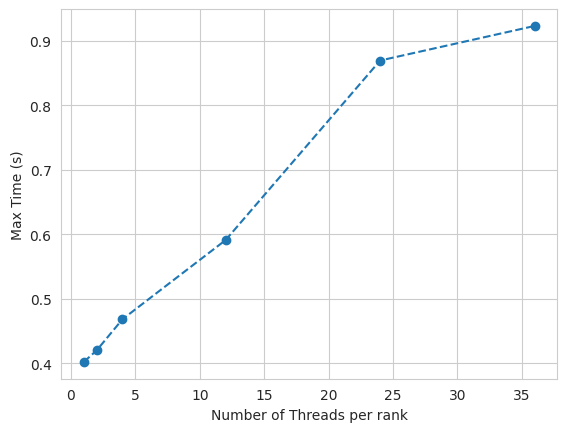

In [5]:
thread_scaling_data = prepare_thread_scaling_data(all_data)
thread_scaling_data.to_csv("thread_scaling_data.txt", sep=" ", index=False)
plot_thread_scaling(thread_scaling_data)

Cray-pat profiles were collecte for mpi traces (`-g mpi`) , omp traces (`-g omp`) and sampled profiles .
Data was extracted from craypat profiles using:

- `pat_report -T -s pe=ALL  -O ca` : Callect call stack iformation for mpi traces. all mpi calls happen on the master threads.
- `pat_report -T -O load_imbalance_thread ` : on openmp traces
- `pat_report   -O ca ` : on sampling data
- `pat_report   -O ca -s pe=ALL ` : on sampling data, saved in `report_pe.txt` files

The times in the craypat profilers already exclude the first step.

In [7]:
import tools
from tools.craypat import extract_mpi_callstack_data

run_dir="/work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs" # Directoring containing profiles for different runs

ppn_list = [288,72,24,12,8] # CPUs per node

summaries = []
for ppn in tqdm.tqdm(ppn_list): # Iterate over runs with different number of threads
    report = f"{run_dir}/nodes192_ppn{ppn}_meshC1536_cray_pat_mpi/report.txt"
    print(f"Processing report: {report}")
    # Parse the report
    profile = extract_mpi_callstack_data(report) # Extract data from text report generated with pat_report
    
    calls = ["USER","MPI_SYNC","MPI"]
    for call in calls:
        summary= profile[call].timing.aggregate({'time':['min','max','mean','std']})
        
        summary['threads']=288/ppn
        summary['call'] = call
        summaries.append(summary)

summary_profile = pd.concat(summaries)
summary_profile["time"]/=99 # Divide by number of time steps minus one (first step excluded)
summary_profile.head(10)

  0%|          | 0/5 [00:00<?, ?it/s]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn288_meshC1536_cray_pat_mpi/report.txt


 20%|██        | 1/5 [00:21<01:24, 21.18s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn72_meshC1536_cray_pat_mpi/report.txt


 40%|████      | 2/5 [00:22<00:28,  9.60s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn24_meshC1536_cray_pat_mpi/report.txt


 60%|██████    | 3/5 [00:25<00:12,  6.40s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn12_meshC1536_cray_pat_mpi/report.txt


 80%|████████  | 4/5 [00:26<00:04,  4.30s/it]

Processing report: /work/z62/z62/lparisiz62/lfric/met-lfric-cirrus/runs/nodes192_ppn8_meshC1536_cray_pat_mpi/report.txt


100%|██████████| 5/5 [00:27<00:00,  5.49s/it]


,time,threads,call
min,0.394829,1.0,USER
max,0.453222,1.0,USER
mean,0.421972,1.0,USER
std,0.007359,1.0,USER
min,0.107310,1.0,MPI_SYNC
max,0.148534,1.0,MPI_SYNC
mean,0.136062,1.0,MPI_SYNC
std,0.006316,1.0,MPI_SYNC
min,0.082878,1.0,MPI
max,0.149472,1.0,MPI


In [8]:
compact_summary_profile = summary_profile.reset_index().pivot(values=['time'],columns=['index'],index=["threads","call"]).reset_index()
compact_summary_profile.to_csv("thread_scaling_mpi.txt", sep=" ", index=False)
compact_summary_profile.head(10)


threads      call      time                              
index                         max      mean       min       std
0         1.0       MPI  0.149472  0.110075  0.082878  0.008543
1         1.0  MPI_SYNC  0.148534  0.136062  0.107310  0.006316
2         1.0      USER  0.453222  0.421972  0.394829  0.007359
3         4.0       MPI  0.128513  0.110837  0.091585  0.004621
4         4.0  MPI_SYNC  0.370955  0.347987  0.306950  0.008532
5         4.0      USER  0.560353  0.526009  0.500794  0.009940
6        12.0       MPI  0.173782  0.140426  0.108353  0.007842
7        12.0  MPI_SYNC  0.525541  0.455400  0.385353  0.018717
8        12.0      USER  0.801585  0.723791  0.645163  0.020455
9        24.0       MPI  0.278284  0.216917  0.165700  0.018219

In [9]:
# Extract maximum time data and compute the difference between user time and time spent in MPI calls
# Does some data wrangling to get the data in a easier format to plot with

time_max_data=compact_summary_profile[[("threads",""),("call",""),("time","max")]] # Select maximum time across all mpi ranks
time_max_data.columns = time_max_data.columns.droplevel(1) # Flatten the column MultiIndex
time_max_data=time_max_data.pivot(values="time", index="threads", columns="call").reset_index() # Shift call type from rows to columns
time_max_data["SYNC -MPI - MPI_SYNC"]=time_max_data["USER"]- time_max_data["MPI_SYNC"]-time_max_data["MPI"] # Compute the difference between user time and time spent in MPI calls
time_max_data=time_max_data.melt(id_vars=["threads"]) # Unpivot call type back to rows, as it is easier to plot with
time_max_data=time_max_data.rename(columns={"value": "time_max"})
time_max_data.to_csv("thread_scaling_mpi_time_max.txt", sep=" ", index=False)
time_max_data.head(10)

,threads,call,time_max
0,1.0,MPI,0.149472
1,4.0,MPI,0.128513
2,12.0,MPI,0.173782
3,24.0,MPI,0.278284
4,36.0,MPI,0.316478
5,1.0,MPI_SYNC,0.148534
6,4.0,MPI_SYNC,0.370955
7,12.0,MPI_SYNC,0.525541
8,24.0,MPI_SYNC,0.621791
9,36.0,MPI_SYNC,0.597093


Text(0, 0.5, 'Max Time (s)')

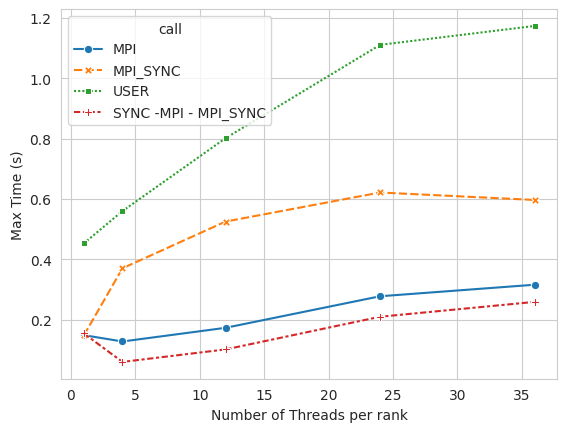

In [10]:
tim_max_data=pd.read_csv("thread_scaling_mpi_time_max.txt", sep=" ")
sns.lineplot(data=time_max_data, x="threads", y="time_max", style="call", hue="call", markers=True, dashes=True)
plt.xlabel("Number of Threads per rank")
plt.ylabel("Max Time (s)")

The plot above shows maximum time in function of the number of threads per tank, in different sections of the code. 
The time spent in user time, a proxy meadure of time spent in computation increases with the number of threads , as well as the time spent in syncronisation. The time spent in actual mpi calls also increases, altough by a less significant margin. However the difference between the time spent in computation and the time spent in mpi, including mpi syncronisation, stays roughly constant although. A possible explaination is that the imbalance is due to random fluctuations in performance between different cores. As these fluctuations are random, and no rank is systematically slower than the others one only observes an increase in syncronisation costs in the computation. This causes high cost spent at global syncronisation calls, dominated by mpi all reduce calls in the solver.